# 3.7 softmax回归的简洁实现

In [6]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..")
import torchvision
# import d2lzh_pytorch as d2l
# from d2l import torch as d2l
print(torch.__version__)

2.1.0


In [7]:
def show_singe_image(image, label):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    fig, ax = plt.subplots()
    ax.imshow(image.view((28, 28)).numpy())  # 假设输入的图像是单通道的灰度图像
    ax.set_title(text_labels[label])
    plt.show()

## 3.7.1 获取和读取数据

In [8]:
def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())

    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter


In [9]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

100.0%


Extracting /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw



100.0%


Extracting /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw



100.0%


Extracting /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw



100.0%

Extracting /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/rainbow/Datasets/FashionMNIST/FashionMNIST/raw



## 3.7.2 定义和初始化模型

In [10]:
num_inputs = 784
num_outputs = 10

# class LinearNet(nn.Module):
#     def __init__(self, num_inputs, num_outputs):
#         super(LinearNet, self).__init__()
#         self.linear = nn.Linear(num_inputs, num_outputs)
#     def forward(self, x): # x shape: (batch, 1, 28, 28)
#         y = self.linear(x.view(x.shape[0], -1))
#         return y
    
# net = LinearNet(num_inputs, num_outputs)

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

from collections import OrderedDict
net = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        # ('flatten', FlattenLayer()),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(num_inputs, 1000)),
        ('sigmoid', nn.Sigmoid()),
        ('linear', nn.Linear(1000, num_outputs))
        # ('softmax', nn.Softmax(dim=1))
    ])
)



In [11]:
net

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (sigmoid): Sigmoid()
  (linear): Linear(in_features=1000, out_features=10, bias=True)
)

In [12]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.normal_(net.linear1.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)
init.constant_(net.linear1.bias, val=0)
net.linear.weight.size(), net.linear.bias.size()

(torch.Size([10, 1000]), torch.Size([10]))

In [13]:
# net.linear2.weight.size()

## 3.7.3 softmax和交叉熵损失函数

In [14]:
loss = nn.CrossEntropyLoss()

## 3.7.4 定义优化算法

In [15]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

## 3.7.5 训练模型

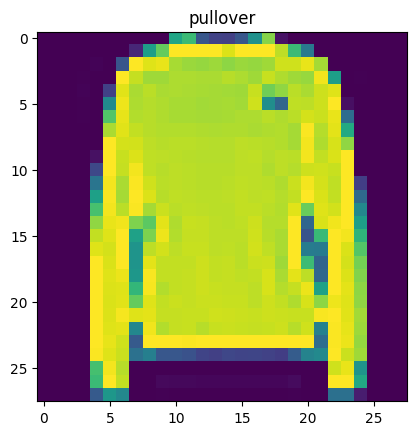

In [16]:
for X, y in train_iter:
    show_singe_image(X[0], y[0])
    # print(X[0].size())
    break

In [18]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))




In [17]:
num_epochs = 5
# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

net = net.to(device='cuda')
# optimizer = optimizer.to(device='cuda')
for name, param in net.named_parameters():
    print(f"Parameter {name} is on device {param.device}")

for X, y in train_iter:
    X = X.to(device='cuda')
    y = y.to(device='cuda')
for X, y in test_iter:
    X = X.to(device='cuda')
    y = y.to(device='cuda')
print("now training")
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
import random
def make_ten_prediction(data_iter):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

    images, labels = [], []
    num_rows, num_cols, num_images = 2, 5, 10
    y_hat = []
    for X, y in data_iter:
        global net
        net = net.to(device='cpu')
        batch_out = net(X)
        for i in range(10):
            r = random.randint(0, 255)
            images.append(X[r])
            labels.append(y[r])
            y_hat.append(text_labels[np.argmax(batch_out[r].detach().numpy())])
        break
    fig, axes = plt.subplots(num_rows, num_cols)


    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                ax = axes[i, j]
                ax.imshow(images[index].view((28, 28)).numpy())
                ax.set_title(
                    text_labels[labels[index].item()] + '\n' + y_hat[index]
                )

In [ ]:
make_ten_prediction(test_iter)

In [ ]:
make_ten_prediction(test_iter)